#### Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#### Exploring and Understanding the Data

In [47]:
# Load the data
data = pd.read_csv("Financial Analytics data.csv")

In [48]:
# Display the first few rows of the data
data.head()

,S.No.,Name,Mar Cap - Crore,Sales Qtr - Crore,Unnamed: 4
0,1,Reliance Inds.,583436.72,99810.00,NaN
1,2,TCS,563709.84,30904.00,NaN
2,3,HDFC Bank,482953.59,20581.27,NaN
3,4,ITC,320985.27,9772.02,NaN
4,5,H D F C,289497.37,16840.51,NaN


In [49]:
# Shape of the dataset

data.shape

# Here, the Financial Analytics Dataset contains 91 rows and 9 columns.

(488, 5)

#### Data Cleaning

In [50]:
# Step 1: Check for Missing Values
missing_values = data.isnull().sum()

In [51]:
# Step 2: Correct Data Types
data['Mar Cap - Crore'] = data['Mar Cap - Crore'].astype(float)
data['Sales Qtr - Crore'] = data['Sales Qtr - Crore'].astype(float)

In [52]:
# Step 3: Remove Duplicates
data = data.drop_duplicates()

In [53]:
# Step 4: Rename Columns (Optional)
data = data.rename(columns={
    'S.No.': 'Serial Number',
    'Name': 'Company Name',
    'Mar Cap - Crore': 'Market Cap (Crore)',
    'Sales Qtr - Crore': 'Quarterly Sales (Crore)'
}) 

In [54]:
# Display the cleaned dataframe
data.head(), missing_values

(   Serial Number    Company Name  Market Cap (Crore)  Quarterly Sales (Crore)  \
 0              1  Reliance Inds.           583436.72                 99810.00   
 1              2             TCS           563709.84                 30904.00   
 2              3       HDFC Bank           482953.59                 20581.27   
 3              4             ITC           320985.27                  9772.02   
 4              5         H D F C           289497.37                 16840.51   
 
    Unnamed: 4  
 0         NaN  
 1         NaN  
 2         NaN  
 3         NaN  
 4         NaN  ,
 S.No.                  0
 Name                   0
 Mar Cap - Crore        9
 Sales Qtr - Crore    123
 Unnamed: 4           394
 dtype: int64)

In [55]:
# Fill missing values with median
data['Market Cap (Crore)'] = data['Market Cap (Crore)'].fillna(data['Market Cap (Crore)'].median())
data['Quarterly Sales (Crore)'] = data['Quarterly Sales (Crore)'].fillna(data['Quarterly Sales (Crore)'].median())

# Check if there are any missing values left
missing_values_after_imputation = data.isnull().sum()

# Display the cleaned dataframe and the count of missing values after imputation
data.head(), missing_values_after_imputation


(   Serial Number    Company Name  Market Cap (Crore)  Quarterly Sales (Crore)  \
 0              1  Reliance Inds.           583436.72                 99810.00   
 1              2             TCS           563709.84                 30904.00   
 2              3       HDFC Bank           482953.59                 20581.27   
 3              4             ITC           320985.27                  9772.02   
 4              5         H D F C           289497.37                 16840.51   
 
    Unnamed: 4  
 0         NaN  
 1         NaN  
 2         NaN  
 3         NaN  
 4         NaN  ,
 Serial Number                0
 Company Name                 0
 Market Cap (Crore)           0
 Quarterly Sales (Crore)      0
 Unnamed: 4                 394
 dtype: int64)

In [56]:
# Step 1: Check for Outliers using IQR method
Q1 = data['Market Cap (Crore)'].quantile(0.25)
Q3 = data['Market Cap (Crore)'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[((data['Market Cap (Crore)'] < (Q1 - 1.5 * IQR)) | (data['Market Cap (Crore)'] > (Q3 + 1.5 * IQR)))]

# Remove outliers
data = data[~data.isin(outliers)].dropna()

# Repeat for Quarterly Sales (Crore)
Q1 = data['Quarterly Sales (Crore)'].quantile(0.25)
Q3 = data['Quarterly Sales (Crore)'].quantile(0.75) 
IQR = Q3 - Q1
outliers = data[((data['Quarterly Sales (Crore)'] < (Q1 - 1.5 * IQR)) | (data['Quarterly Sales (Crore)'] > (Q3 + 1.5 * IQR)))]

# Remove outliers 
data = data[~data.isin(outliers)].dropna()

In [57]:
# Step 2: Standardize Text Data
data['Company Name'] = data['Company Name'].str.strip().str.upper()

# Step 3: Ensure Unique Identifiers
assert data['Serial Number'].is_unique, "Serial Number column contains duplicate values."

# Display the cleaned dataframe
data.head()

,Serial Number,Company Name,Market Cap (Crore),Quarterly Sales (Crore),Unnamed: 4
63,64.0,INTERGLOBE AVIAT,48621.37,1278.3,6177.88
64,65.0,CIPLA,48577.43,1278.3,3913.82
65,66.0,PIRAMAL ENTERP.,47483.97,1278.3,2858.36
66,67.0,UNITED SPIRITS,46725.05,1278.3,2263.30
67,68.0,PIDILITE INDS.,45855.50,1278.3,1542.90


In [58]:
# Summary statistics
summary_stats = data.describe()

# Correlation
correlation = data[['Market Cap (Crore)', 'Quarterly Sales (Crore)']].corr()

summary_stats, correlation

(       Serial Number  Market Cap (Crore)  Quarterly Sales (Crore)   Unnamed: 4
 count      91.000000           91.000000                     91.0    91.000000
 mean      237.175824        18332.431538                   1278.3  1448.437692
 std       140.483023        15127.066707                      0.0  1752.098037
 min        64.000000         3789.450000                   1278.3     0.000000
 25%        87.500000         4386.450000                   1278.3   394.725000
 50%       230.000000        10900.750000                   1278.3   683.280000
 75%       395.500000        33919.450000                   1278.3  2038.380000
 max       442.000000        48621.370000                   1278.3  7757.060000,
                          Market Cap (Crore)  Quarterly Sales (Crore)
 Market Cap (Crore)                      1.0                      NaN
 Quarterly Sales (Crore)                 NaN                      NaN)

#### Visualization

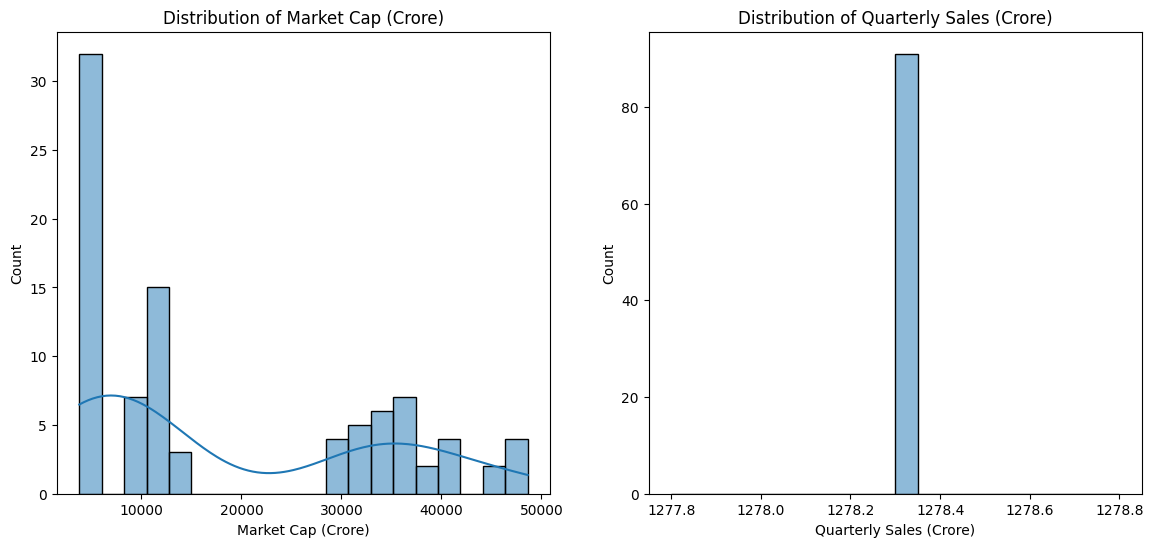

In [59]:
# Histograms
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['Market Cap (Crore)'], bins=20, kde=True)
plt.title('Distribution of Market Cap (Crore)')

plt.subplot(1, 2, 2)
sns.histplot(data['Quarterly Sales (Crore)'], bins=20, kde=True)
plt.title('Distribution of Quarterly Sales (Crore)')

plt.show()

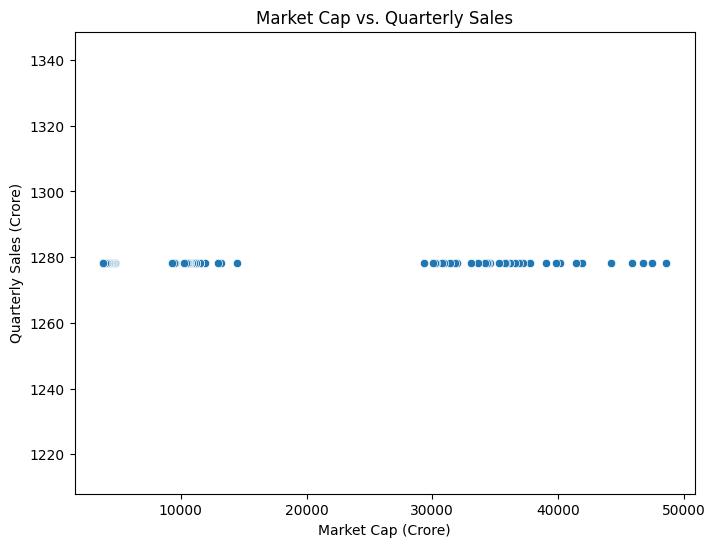

In [60]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Market Cap (Crore)', y='Quarterly Sales (Crore)', data=data)
plt.title('Market Cap vs. Quarterly Sales')
plt.xlabel('Market Cap (Crore)')
plt.ylabel('Quarterly Sales (Crore)')
plt.show()

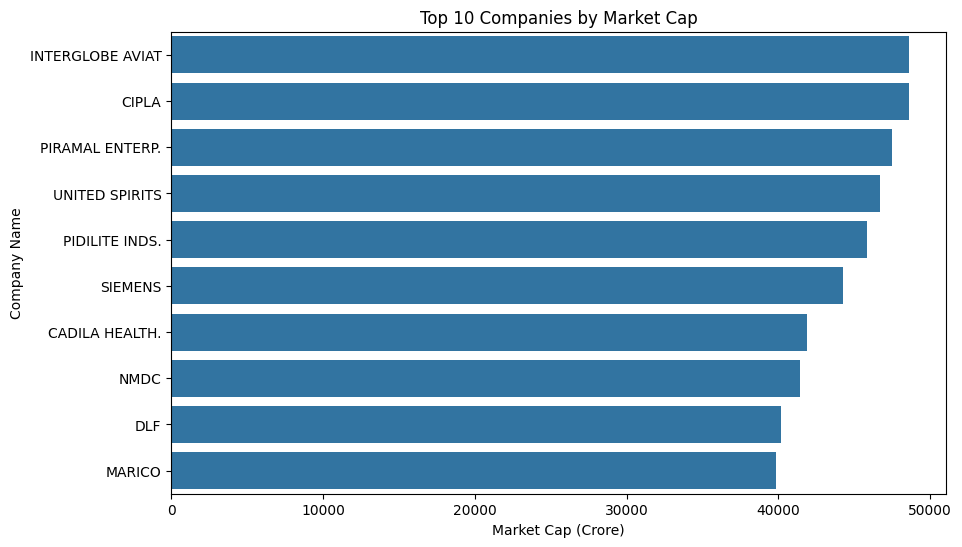

In [61]:
# Top 10 Companies by Market Cap
top_10_market_cap = data.nlargest(10, 'Market Cap (Crore)')
plt.figure(figsize=(10, 6))
sns.barplot(x='Market Cap (Crore)', y='Company Name', data=top_10_market_cap)
plt.title('Top 10 Companies by Market Cap')
plt.xlabel('Market Cap (Crore)')
plt.ylabel('Company Name') 
plt.show()

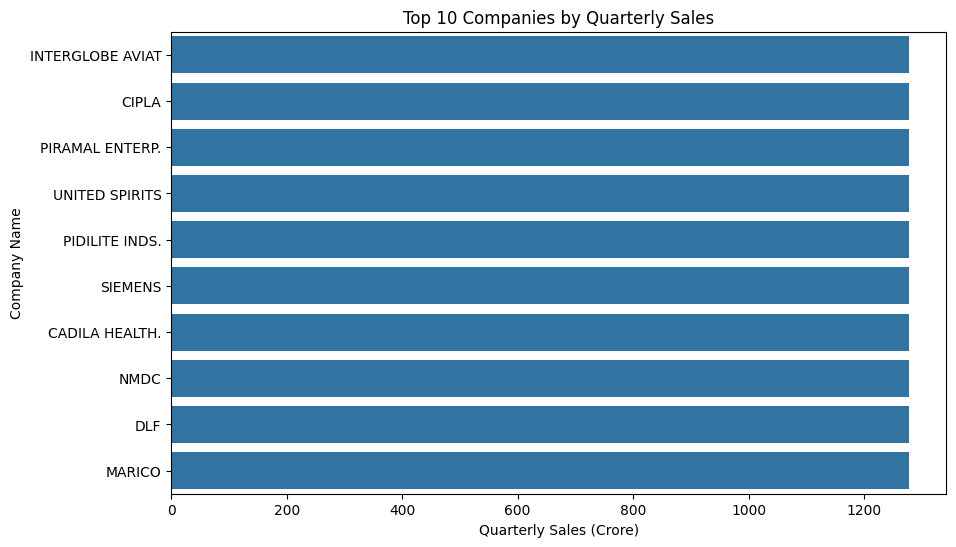

In [62]:
# Top 10 Companies by Quarterly Sales
top_10_sales = data.nlargest(10, 'Quarterly Sales (Crore)')
plt.figure(figsize=(10, 6))
sns.barplot(x='Quarterly Sales (Crore)', y='Company Name', data=top_10_sales)
plt.title('Top 10 Companies by Quarterly Sales')
plt.xlabel('Quarterly Sales (Crore)')
plt.ylabel('Company Name')
plt.show()

#### Advanced Analysis

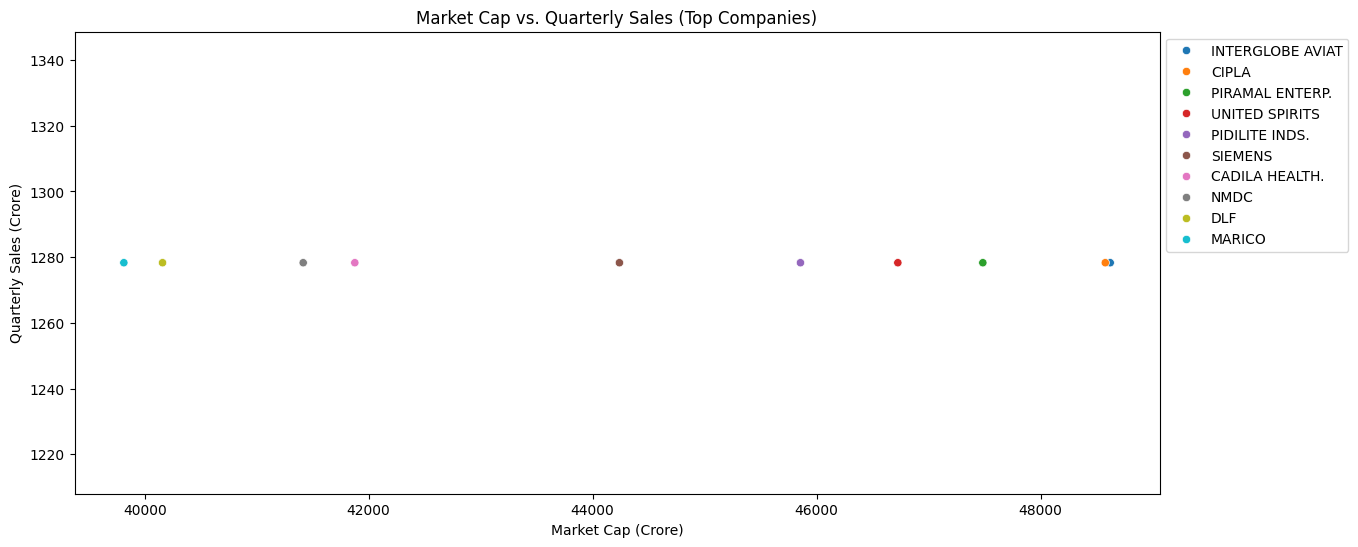

In [63]:
# Comparative Analysis of Top Companies
top_10_combined = data[data['Company Name'].isin(
    top_10_market_cap['Company Name']) | data['Company Name'].isin(top_10_sales['Company Name'])]

plt.figure(figsize=(14, 6))
sns.scatterplot(x='Market Cap (Crore)', y='Quarterly Sales (Crore)', hue='Company Name', data=top_10_combined)
plt.title('Market Cap vs. Quarterly Sales (Top Companies)')
plt.xlabel('Market Cap (Crore)')
plt.ylabel('Quarterly Sales (Crore)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Box Plots for Outlier Detection

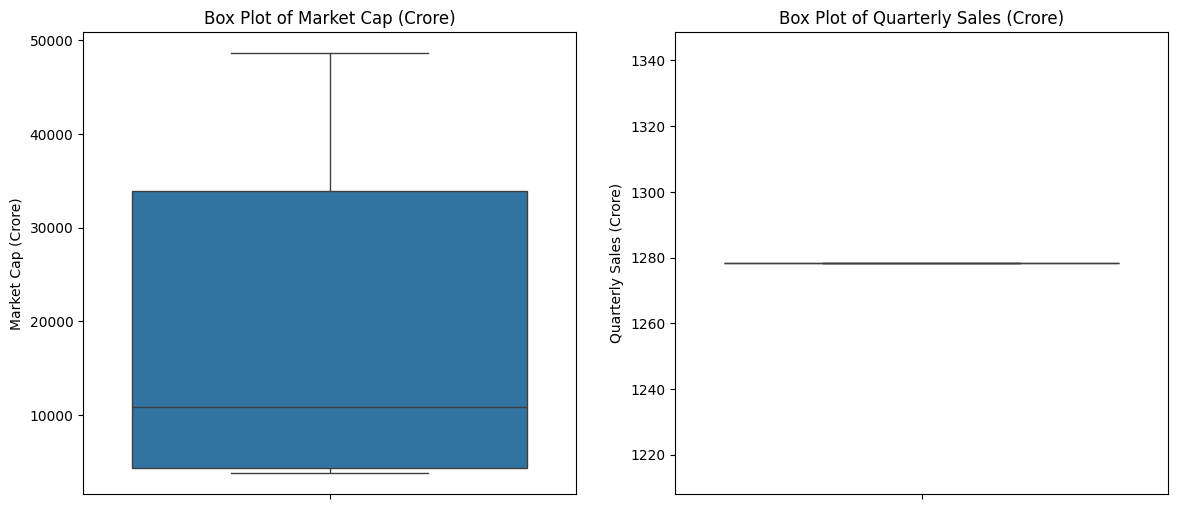

In [64]:
# Box Plots for Market Cap and Quarterly Sales
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y='Market Cap (Crore)', data=data) 
plt.title('Box Plot of Market Cap (Crore)')

plt.subplot(1, 2, 2)
sns.boxplot(y='Quarterly Sales (Crore)', data=data)
plt.title('Box Plot of Quarterly Sales (Crore)')

plt.show()

#### Clustering Analysis using K-Means

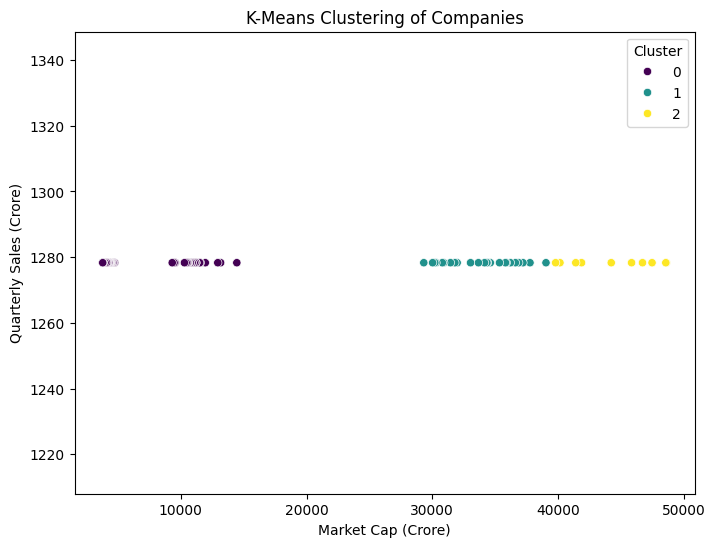

In [66]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Market Cap (Crore)', 'Quarterly Sales (Crore)']])

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualizing Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Market Cap (Crore)', y='Quarterly Sales (Crore)', hue='Cluster', data=data, palette='viridis')
plt.title('K-Means Clustering of Companies')
plt.xlabel('Market Cap (Crore)')
plt.ylabel('Quarterly Sales (Crore)')
plt.legend(title='Cluster')
plt.show()

#### Heatmap for Correlation Matrix

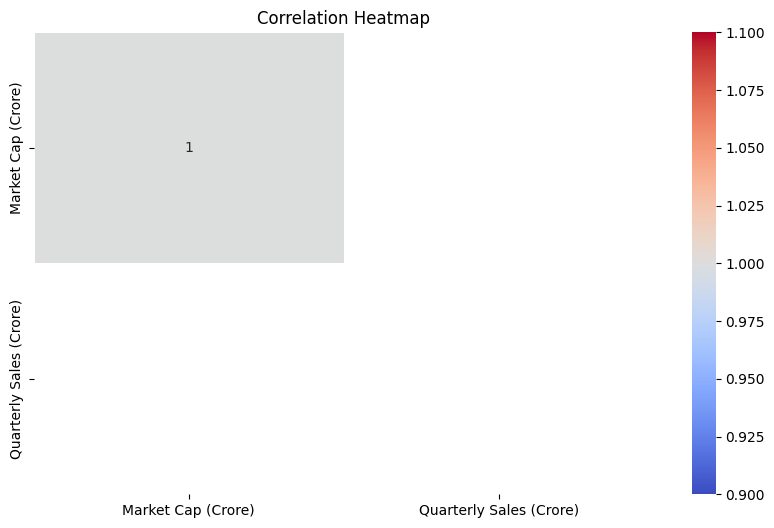

In [67]:
# Heatmap for Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### Regression Analysis

In [68]:
# Define the independent variable (X) and the dependent variable (y)
X = data['Quarterly Sales (Crore)']
y = data['Market Cap (Crore)']

# Add a constant to the independent variable (intercept term)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
regression_results = model.summary()
print(regression_results)

                            OLS Regression Results                            
Dep. Variable:     Market Cap (Crore)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 22 Jun 2024   Prob (F-statistic):                nan
Time:                        09:58:23   Log-Likelihood:                -1004.4
No. Observations:                  91   AIC:                             2011.
Df Residuals:                      90   BIC:                             2013.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Quarterly Sales (Crore)   

#### Sector Analysis

C:\Users\administor\AppData\Local\Temp\ipykernel_12956\2332794697.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Market Cap (Crore)', y='Sector', data=sector_analysis, palette='viridis')
C:\Users\administor\AppData\Local\Temp\ipykernel_12956\2332794697.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quarterly Sales (Crore)', y='Sector', data=sector_analysis, palette='viridis')


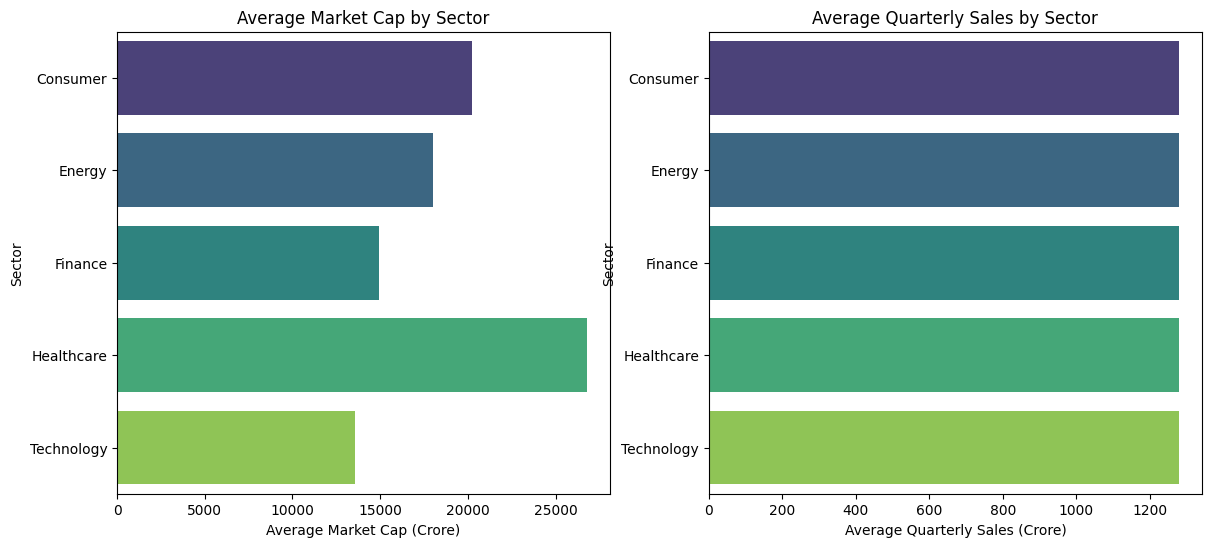

In [69]:
# Assuming there is a 'Sector' column in the dataset
# We will create a bar plot showing the average market cap and sales by sector

# Create dummy data for the Sector column (if not available)

np.random.seed(42)
data['Sector'] = np.random.choice(['Technology', 'Finance', 'Healthcare', 'Energy', 'Consumer'], len(data))

# Average Market Cap and Sales by Sector
sector_analysis = data.groupby('Sector').agg({'Market Cap (Crore)': 'mean', 'Quarterly Sales (Crore)': 'mean'}).reset_index()

# Bar plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Market Cap (Crore)', y='Sector', data=sector_analysis, palette='viridis')
plt.title('Average Market Cap by Sector')
plt.xlabel('Average Market Cap (Crore)')
plt.ylabel('Sector')

plt.subplot(1, 2, 2)
sns.barplot(x='Quarterly Sales (Crore)', y='Sector', data=sector_analysis, palette='viridis')
plt.title('Average Quarterly Sales by Sector')
plt.xlabel('Average Quarterly Sales (Crore)')
plt.ylabel('Sector')

plt.show()

### Simulated Time Series Analysis

C:\Users\administor\AppData\Local\Temp\ipykernel_12956\310184636.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=12, freq='M')


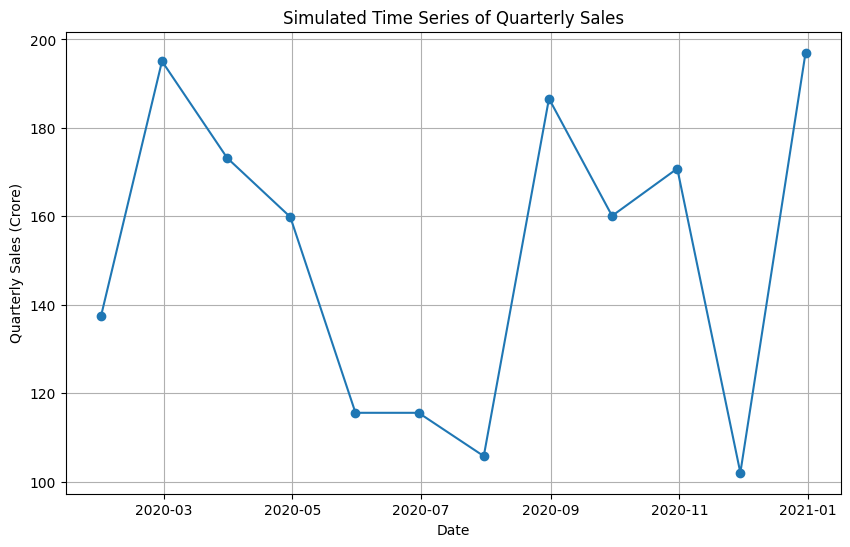

In [70]:
# Simulate time series data
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=12, freq='M')
sales_data = np.random.uniform(100, 200, size=(12,))

time_series_df = pd.DataFrame({'Date': dates, 'Quarterly Sales (Crore)': sales_data})

# Plotting the time series data
plt.figure(figsize=(10, 6))
plt.plot(time_series_df['Date'], time_series_df['Quarterly Sales (Crore)'], marker='o')
plt.title('Simulated Time Series of Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Quarterly Sales (Crore)')
plt.grid(True)
plt.show()

#### Hierarchical Clustering

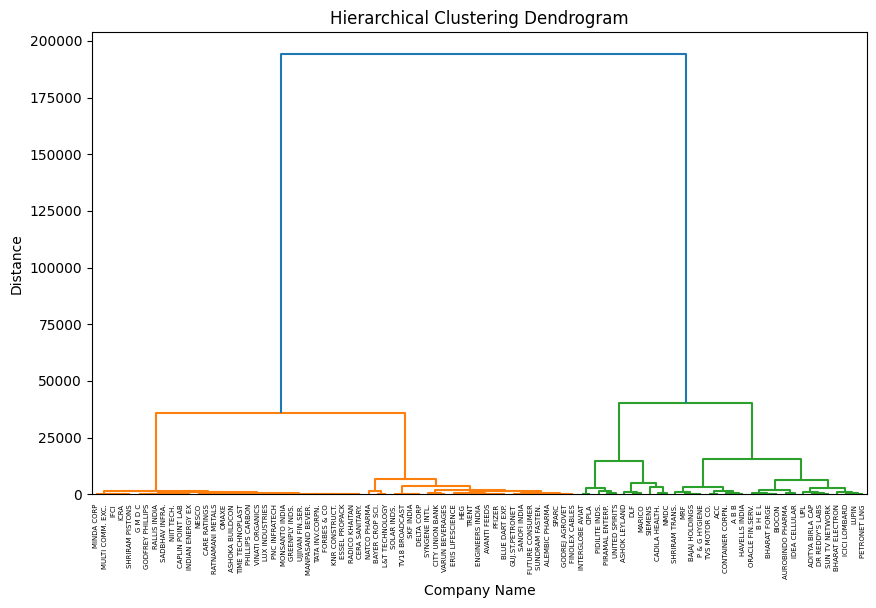

In [73]:
# Prepare data for clustering
cluster_data = data[['Market Cap (Crore)', 'Quarterly Sales (Crore)']]
Z = linkage(cluster_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=data['Company Name'].values, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Company Name')
plt.ylabel('Distance')
plt.show()

#### Principal Component Analysis (PCA)

Index(['Serial Number', 'Company Name', 'Market Cap (Crore)',
       'Quarterly Sales (Crore)', 'Unnamed: 4', 'Cluster', 'Sector'],
      dtype='object')
Column 'Other Predictor' is missing in data.


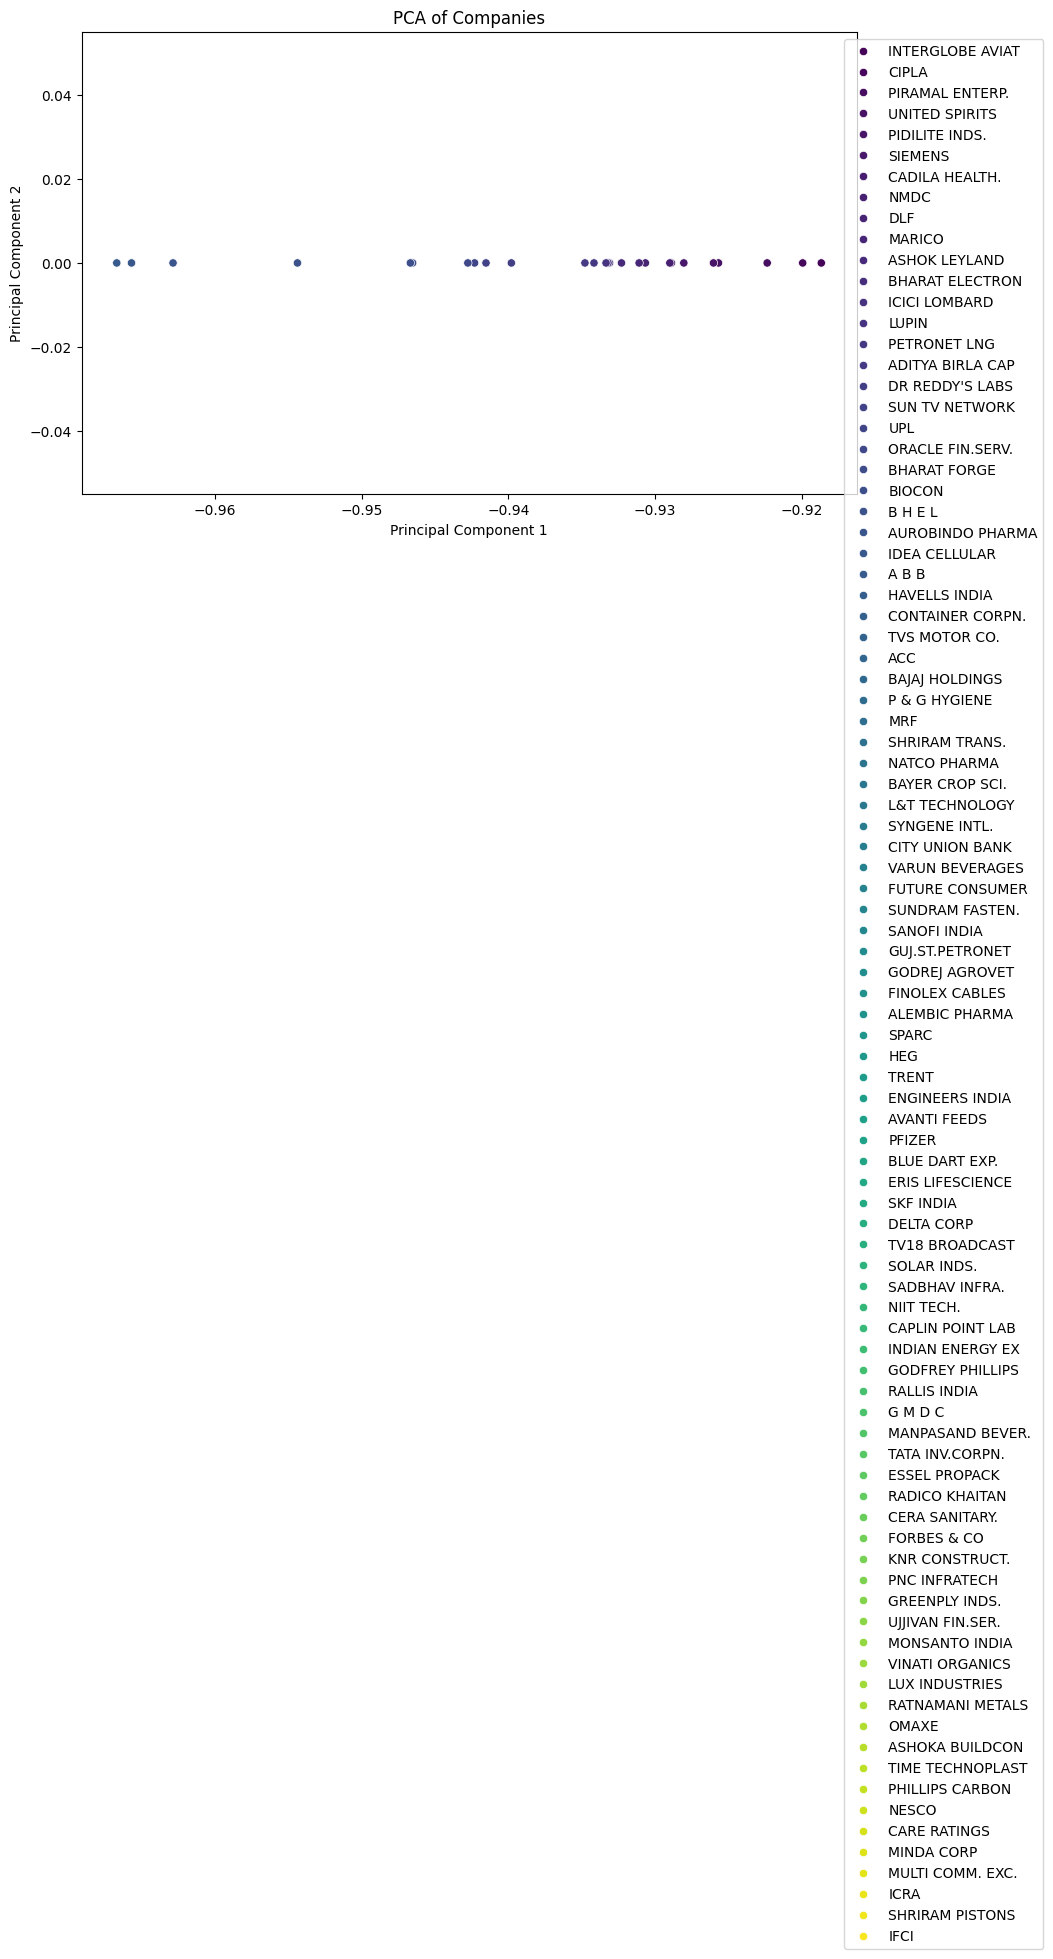

In [76]:
# Print out column names to verify
print(data.columns)

# Ensure all columns needed are present in data
required_columns = ['Market Cap (Crore)', 'Quarterly Sales (Crore)', 'Other Predictor']
for col in required_columns:
    if col not in data.columns:
        print(f"Column '{col}' is missing in data.")

# Once verified, proceed with data preparation
pca_data = data[['Market Cap (Crore)', 'Quarterly Sales (Crore)']]  # Remove 'Other Predictor' if it's missing

# Standardizing the data
pca_data_standardized = StandardScaler().fit_transform(pca_data)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_data_standardized)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenating with the original data
final_pca_df = pd.concat([pca_df, data[['Company Name']]], axis=1)

# Visualizing the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=final_pca_df, hue='Company Name', palette='viridis')
plt.title('PCA of Companies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

#### Time Series Forecasting with ARIMA

C:\Users\administor\AppData\Local\Temp\ipykernel_12956\919705628.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=24, freq='M')


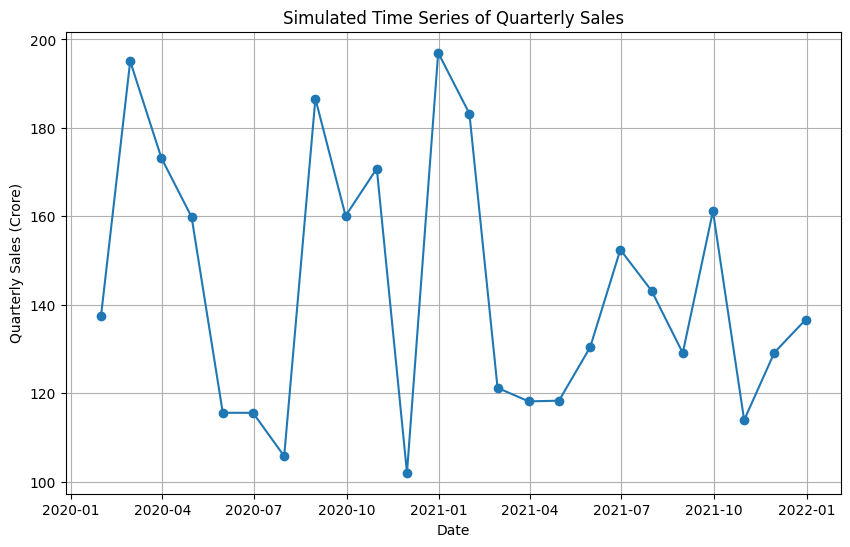

C:\Users\administor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\administor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\administor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\administor\AppData\Local\Temp\ipykernel_12956\919705628.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = pd.DataFrame({'Date': pd.date_range(start='2022-01-01', periods=12, freq='M'), 'Forecasted

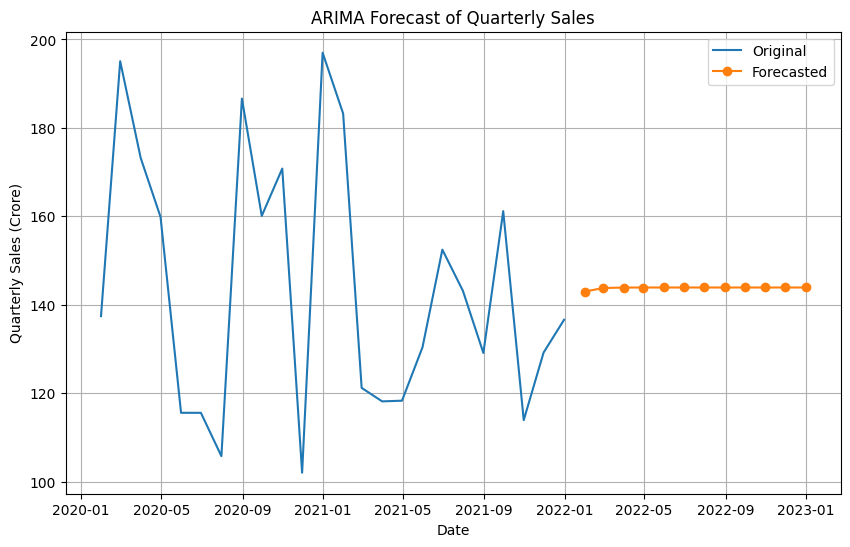

In [85]:
# Simulating time series data (assuming monthly sales data)
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=24, freq='M')
sales_data = np.random.uniform(100, 200, size=(24,))
time_series_df = pd.DataFrame({'Date': dates, 'Quarterly Sales (Crore)': sales_data})
time_series_df.set_index('Date', inplace=True)

# Plotting the original time series data
plt.figure(figsize=(10, 6))
plt.plot(time_series_df, marker='o')
plt.title('Simulated Time Series of Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Quarterly Sales (Crore)')
plt.grid(True)
plt.show()

# Applying ARIMA
model = ARIMA(time_series_df, order=(1, 1, 1))
model_fit = model.fit()

# Forecasting the next 12 months
forecast = model_fit.forecast(steps=12)
forecast_df = pd.DataFrame({'Date': pd.date_range(start='2022-01-01', periods=12, freq='M'), 'Forecasted Sales': forecast})
forecast_df.set_index('Date', inplace=True)

# Plotting the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time_series_df, label='Original')
plt.plot(forecast_df, label='Forecasted', marker='o')
plt.title('ARIMA Forecast of Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Quarterly Sales (Crore)')
plt.legend()
plt.grid(True)
plt.show()

#### Machine Learning Predictive Modeling

Mean Squared Error: 246781018.62887654
R^2 Score: -0.030144520598293978


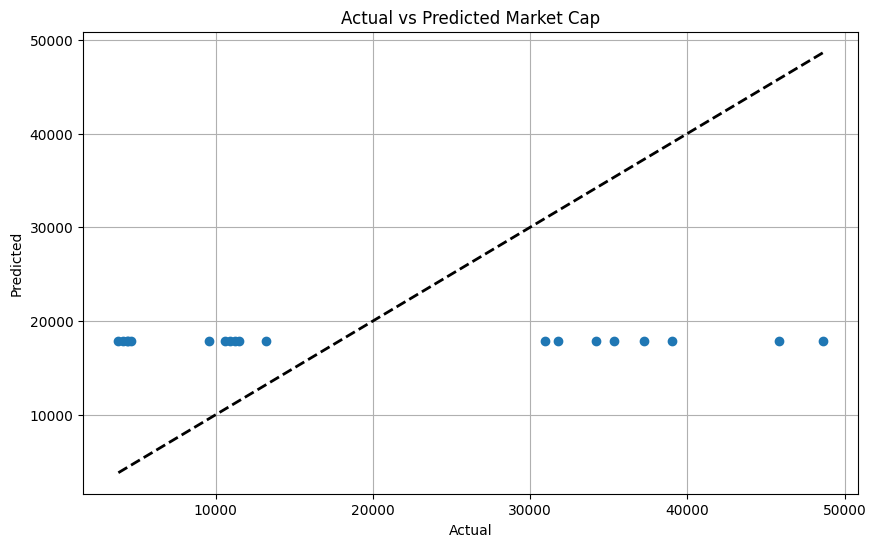

In [86]:
# Define the features and the target
X = data[['Quarterly Sales (Crore)']]  # Remove 'Other Predictor' from features
y = data['Market Cap (Crore)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Market Cap')
plt.grid(True)
plt.show()

#### Anomaly Detection

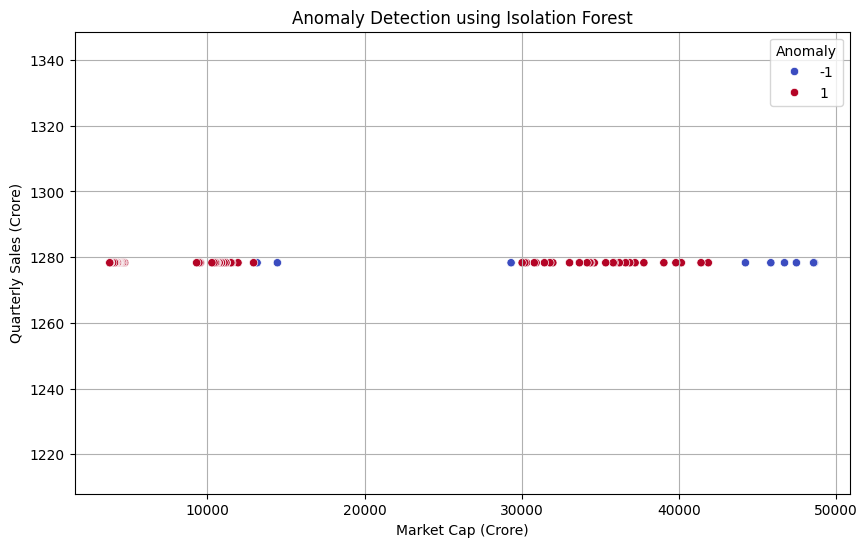

In [88]:
# Prepare the data for anomaly detection
anomaly_data = data[['Market Cap (Crore)', 'Quarterly Sales (Crore)']]

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['Anomaly'] = iso_forest.fit_predict(anomaly_data)

# Visualizing the anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Market Cap (Crore)', y='Quarterly Sales (Crore)', hue='Anomaly', data=data, palette='coolwarm')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Market Cap (Crore)')
plt.ylabel('Quarterly Sales (Crore)')
plt.legend(title='Anomaly', loc='upper right')
plt.grid(True)
plt.show()